The **Lecture slides** can be found [here](https://github.com/GDSL-UL/wma/raw/main/lectures/w04.html).

In this lab, we will explore and familiarise with some of the most common data formats for web mapping: GeoJSON and Mbtiles. 

## GeoJSON

To get familiar with the format, we will start by creating a GeoJSON file from scratch. Head over to the following website:

<https://geojson.io/>

In there, we will create together a small example to better understand the building blocks of this file format.

<img src="../labs_img/geojson.png" width="80%">

We will pay special attention to the following aspects:

-   Readability.
-   Coordinate system.
-   Ability to add non-spatial information attached to each record.
-   How to save it as a file.

<div class="alert alert-success">

**Excercise**:

Create a GeoJSON file for the following data and save them to separate files:

1.  Your five favourite spots in Liverpool
2.  A polygon of what you consider to be the boundary of the neighbourhood where you live and the city centre of Liverpool. Name each.
3.  A route that captures one of your favourite walks around the Liverpool region

If you are comfortable, upload the files to Microsoft Teams to share them with peers.

</div>

### GeoJSON in Python

With the files from the exercise at hand, we will learn how to open them in a Python environment. Then, let's begin by importing the necessary libraries; `geojson` is used for handling GeoJSON files.


In [1]:
import geopandas as gpd

ModuleNotFoundError: No module named 'geopandas'

Now, place the geojson files you have created in the data folder used in these sessions. As always, the data folder should be stored in the directory where the notebook is running from. For this example, we will assume that the file is called `map.geojson`. We can read the file as:


In [2]:
liverpool = gpd.read_file("../data/map.geojson")
liverpool.head()

,geometry
0,POINT (-2.95623 53.39041)
1,"LINESTRING (-2.95561 53.39037, -2.95555 53.389..."
2,"POLYGON ((-2.96760 53.40312, -2.96760 53.40017..."


We can also plot and explore the content of the GeoDataFrame with `Folium`. Folium, which we will see more in detail later on, helps create interactive maps from data stored in `geopandas.GeoDataFrame`.


In [3]:
import folium 

liverpool_centroid = (53.41058,	-2.97794)
# Create a Folium map centered around this point
map = folium.Map(location=liverpool_centroid, zoom_start=13, tiles="CartoDB.DarkMatterNoLabels")

# Add the liverpool data to the map, this will plot each geometry in the GeoDataFrame
folium.GeoJson(liverpool).add_to(map)
map

Once read, the geojson behaves exactly like any GeoDataFrame we have seen so far. We can therefore operate on it and tap into the functionality from `pandas` and `geopandas`. For example, we can and reproject the layer to the to British National Grid.


In [4]:
liverpool_bng = liverpool.to_crs(crs = "EPSG: 27700")

When we inspected our geojson, we noted that the spatial data is stored in the following format `POINT (-2.977367 53.40753)`. This is called "well known text" (`wkt`) and is a representation that spatial databases like PostGIS use as well. Another way to store spatial data as text for storage or transfer, less (human) readable but more efficient is the "well known blurb" (`wkb`). We can use the `shapely` library to handle the WKT representation of the geometry and then convert it to WKB format.


In [5]:
from shapely import wkt
from shapely.geometry import Point
import shapely.wkb

# Load the WKT representation of the point
wkt_string = "POINT (-2.977367 53.40753)"

# Convert the WKT representation into a Shapely Point object
point = wkt.loads(wkt_string)

# Convert the Point object into WKB format
wkb_data = shapely.wkb.dumps(point)
wkb_data.hex()

'01010000005e8429caa5d107c0c7116bf129b44a40'

<div class="alert alert-success">
    
**Excercise**:
-   Read the `GeoJSON` created for your favorite walks in Liverpool and calculate their length

</div>

Once you are happy with the data as we will hypothetically need it, you can write it out to any other file format supported in `geopandas`. For
example, we can create a Geopackge file with the same information. For this, we can use the function `to_file`. See an example below:


In [6]:
import geopandas as gpd

# 读取GeoJSON文件
file_path = "../data/map.geojson"
walks = gpd.read_file(file_path)

# 计算每条路线的长度
# 转换参考系到英国国家网格, EPSG:27700
walks = walks.to_crs(epsg=27700)
# 计算每条路线的长度
walks["length"] = walks["geometry"].length

print(walks.head())

# Write 'liverpool_bng' to a GeoPackage file
# liverpool_bng.to_file("../data/liverpool_bng.gpkg", layer="liverpool_bng", driver="GPKG")
walks.to_file("../data/walks.gpkg", layer="walks", driver="GPKG")

                                            geometry       length
0                      POINT (336503.713 388600.612)     0.000000
1  LINESTRING (336544.760 388595.961, 336547.058 ...  2063.411570
2  POLYGON ((335766.617 390025.228, 335762.169 38...  1264.154449


## Tilesets and `Mbtiles`
In this section we will dive into the concept of tiles to understand why they have been so transformative in the world of web mapping. We have
already seen the usage of tilesets above with `folium` and with `contextily` (although within a static context). We will see that `folium`, integrates different tileset options already.

For this section, let's start by getting the building footprints from OpenStreetMap with `osmnx`


In [7]:
import osmnx as ox
tags = {"building": True} #OSM tags
buildings = ox.features_from_place("Liverpool, UK", tags = tags) 
buildings = buildings.reset_index()
# sometimes building footprints are represented by Points, let's disregard them
buildings = buildings[(buildings.geometry.geom_type == 'Polygon') | (buildings.geometry.geom_type == 'MultiPolygon')]

<Axes: >

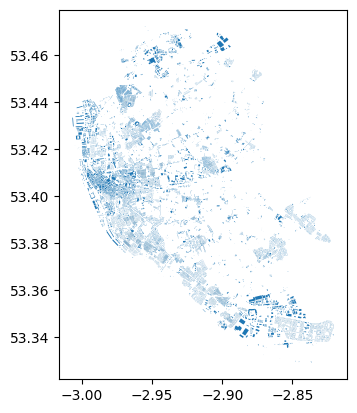

In [8]:
buildings.plot()

Let's save the GeoDataFrame a geojson and call it `buildings_liverpool.geojson`.


In [9]:
buildings[['osmid','geometry']].to_file('../data/buildings_liverpool.geojson',  driver='GeoJSON')

Then, register for a MapBox account [here](https://account.mapbox.com/auth/signup/?route-to=%22https%3A%2F%2Faccount.mapbox.com%2Faccess-tokens%2F%22).

### Optional: Generating .mbtiles in Python

In Python, you can use `togeojsontiles` to make dynamic `.mbtiles` files. This is useful to visualize large data appropriately at any zoom level.
**This step cannot be ran on University Machines**
It requires the installation of `tippecanoe` on your machine. Follow the corresponding instructions for [Windows](https://gist.github.com/ryanbaumann/e5c7d76f6eeb8598e66c5785b677726e) and for [MAC](https://github.com/mapbox/tippecanoe)

In [12]:
# pip install togeojsontiles
%pip install togeojsontiles


from togeojsontiles import geojson_to_mbtiles

# 操了, 这个B tippcanoe只能在linux上运行
TIPPECANOE_DIR = '/usr/local/bin/'

# Convert GeoJSON to .mbtiles
togeojsontiles.geojson_to_mbtiles(
    filepaths=['../data/buildings_liverpool.geojson'],
    tippecanoe_dir=TIPPECANOE_DIR,
    mbtiles_file='liverpool.mbtiles',
    maxzoom=14)

Note: you may need to restart the kernel to use updated packages.


NameError: name 'togeojsontiles' is not defined

You can also try **uploading** it directly to Mapbox. This part of the code has not been tested so it should serve as guidance.

In [13]:
import requests
import os

# Define your Mapbox token
# public token: pk.eyJ1IjoieW9uZ2hlbmciLCJhIjoiY2x0NXFkYW56MDNkdTJtbXY0OWtobGVnMCJ9.7eqyKK-FF_kx9xe_cr1EKA
# envs456 token: sk.eyJ1IjoieW9uZ2hlbmciLCJhIjoiY2x0NXFtaDN4MDAwbzJqbXRwNXJtMndlOSJ9.DYNnhoetg-nGOmpThlg4jg
mapbox_token = "sk.eyJ1IjoieW9uZ2hlbmciLCJhIjoiY2x0NXFtaDN4MDAwbzJqbXRwNXJtMndlOSJ9.DYNnhoetg-nGOmpThlg4jg"

# Endpoint for Mapbox Tiling Service uploads
url = 'https://api.mapbox.com/uploads/v1/mapbox'

# Path to your .mbtiles file
mbtiles_file_path = '../data/liverpool.mbtiles'

# Prepare the headers
headers = {
    'Authorization': f'Bearer {mapbox_token}',
    'Content-Type': 'application/json'
}

# Prepare the data for the POST request
with open(mbtiles_file_path, 'rb') as file:
    files = {'file': file}
    response = requests.post(url, headers=headers, files=files)

# Check the response
if response.status_code == 200:
    print("Upload initiated successfully.")
    print(response.json())
else:
    print("Failed to initiate upload.")
    print(response.text)

FileNotFoundError: [Errno 2] No such file or directory: '../data/liverpool.mbtiles'

***The optional steps end here***

### Uploading to **Mapbox Studio**: 

After creating the `.mbtiles` file, you can upload it *manually* to Mapbox Studio (unless you managed to make the cell above work):

- Navigate to Mapbox Studio.
- Start a New Style and chose a template (Monochrome, blank etc.)
  
<img src="../labs_img/mapboxstyles.png" width="80%">

- Upload the `liverpool.mbtiles` (if you created it) or the `liverpool.geojson`. Press the **+** symbol, `Custom Layer` or `Data Visualisation`, `Upload Data`, and choose your file
  
<img src="../labs_img/mapbox_upload.png" width="80%">

- Once uploaded, you should see your layer in the existing sources. 

<img src="../labs_img/mapbox_select.png" width="80%">

- Style it according to your requirements: It should look like a nicer version of this:
  
<img src="../labs_img/mapbox_building_studio.png" width="80%">

Or through *scripting* with Mapbox's Uploads API (see above)

### Visualizing the Tiles with `Folium`:

First, we need to get the `id` of your Mapbox style by copying its url:

<img src="../labs_img/mapbox_styleid.png" width="80%">

*url example*: [mapbox://styles/gabrif/clrpby9lc00a501pecacz8b7h](mapbox://styles/gabrif/clrpby9lc00a501pecacz8b7h)

the `style_id` is the last section of the URL, in this case `clrpby9lc00a501pecacz8b7h`

Then, we can use `folium`, which we will more in detail later on, and use our tileset. Folium essentially allows us to create interactive maps, usually starting from data stored in a `GeoDataFrame`. While folium provides a series of built-in tilesets, here it is demonstrated how to employ one's own.

In [14]:
# Create a Folium map centered at a specific location
import folium

mapbox_user = 'gabrif'
mapbox_token = ''
style_id = 'clrpby9lc00a501pecacz8b7h' 

tiles = 'https://api.mapbox.com/styles/v1/'+mapbox_user+'/'+style_id+'/tiles/256/{z}/{x}/{y}?access_token='+mapbox_token
map = folium.Map(location=[53.406872, -2.973286], zoom_start=14,
               tiles=tiles,
               attr='Mapbox')

# Display the map
map